# ASCII ART

41600
(208, 200)


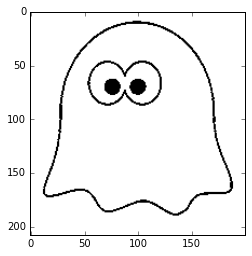

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import colorsys
import copy
import time
import sys
import cv2
import random
from tqdm import tqdm
from PIL import Image
from scipy.ndimage.interpolation import shift

from sklearn import neural_network as nn

#file_name = 'dragon_200.png'
#file_name = 'dragon_800.png'

#file_name = 'ghost_100.png'
file_name = 'ghost_200.png'
#file_name = 'ghost_400.png'

img = cv2.imread(file_name, 0) # load grayscale
img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)[1]
print(img.size)
print(img.shape)
plt.imshow(img, cmap='gray')

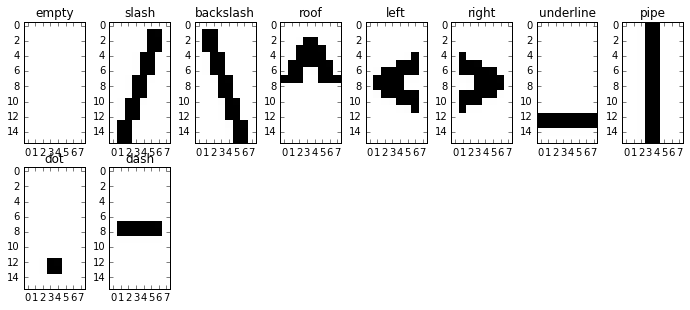

In [81]:
train_set_length = 7

def get_train_set():
    train = [('empty.png', ' '),
             ('slash.png', '/'),
             ('backslash.png', '\\'),
             ('roof.png', '^'),
             ('left.png', '<'),
             ('right.png', '>'),
             ('underline.png', '_'),
             ('pipe.png', '|'),
             ('dot.png', '.'),
             ('dash.png', '-')]
    
    #chars = 'abcdefghijklmnopqrstuvwxyz'
    chars = 'abcdefghijkl'
    chars = ''
    for ch in chars:
        train.append(("{}.png".format(ch), ch))
    
    train_set_length = len(train)
    result = []
    
    plt.figure(figsize=(12, 10))
    for index, pattern in enumerate(train):        
        img = cv2.imread("ascii/{}".format(pattern[0]), 0) # load grayscale
        img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)[1]
        plt.subplot(4, 8, index + 1)
        plt.imshow(img, interpolation='none', cmap='gray',  vmin=0, vmax=1)
        plt.title(pattern[0].split('.')[0])
        
        onehot = [0] * len(train)
        onehot[index] = 1
        result.append((img, pattern[1], onehot))
        
    return result
    plt.tight_layout()
    
train_set = get_train_set()
train_set_unique = np.copy(train_set)

In [82]:
def get_tile_from_prob(onehot_probs):
    i = np.argmax(onehot_probs)
    return train_set_unique[i][0]

In [83]:
TILE_WIDTH = 8
TILE_HEIGTH = 16

class Tile:

    def __init__(self, pixels):
        self.pixels = pixels
    
    def get_pixel(self, x, y):
        return self.pixels[x][y]
        
    def flatten(self):
        return np.array(self.pixels).flatten()
        
def tile_equals(tile1, tile2):
    return np.array_equal(tile1.pixels.flatten(), tile2.pixels.flatten())


In [84]:
WIDTH = img.shape[1]
HEIGHT = img.shape[0]

assert(WIDTH % TILE_WIDTH == 0 and HEIGHT % TILE_HEIGTH == 0)

tiles_x = WIDTH // TILE_WIDTH
tiles_y = HEIGHT // TILE_HEIGTH

def get_tiles_from_img(img):
    tiles = []
    for row in range(tiles_y):
        for col in range(tiles_x):
            tile_pixels = img[row * TILE_HEIGTH:(row + 1) * TILE_HEIGTH,
                              col * TILE_WIDTH:(col + 1) * TILE_WIDTH]
            tiles.append(Tile(np.array(tile_pixels)))
                         
    result = np.array(tiles)
    print("Returns tiles of shape: ", result.shape)
    return result

In [85]:
tiles = get_tiles_from_img(img)

Returns tiles of shape:  (325,)


In [86]:
def show_tiles(tiles):
    reshaped_tiles = tiles.reshape(tiles_y, tiles_x)
    pixels = np.empty([HEIGHT, WIDTH])
    
    for y in range(tiles_y):
        for x in range(tiles_x):
            tile = reshaped_tiles[y][x].pixels
            pixels[np.ix_([*range(y * TILE_HEIGTH, (y+1) * TILE_HEIGTH)],
                          [*range(x * TILE_WIDTH, (x+1) * TILE_WIDTH)])] = tile
    
    im = Image.fromarray(np.uint8(pixels))
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title('Original')
    
    plt.gca().axes.get_xaxis().set_ticks(np.arange(-0.5,HEIGHT-0.5,TILE_WIDTH))
    plt.gca().axes.get_yaxis().set_ticks(np.arange(-0.5,WIDTH-0.5,TILE_HEIGTH))

    plt.gca().axes.set_yticklabels([])
    plt.gca().axes.set_xticklabels([])
    plt.grid()
    
    
    plt.subplot(1,2,2)
    plt.imshow(im, interpolation='none', cmap='gray',  vmin=0, vmax=1)
    plt.title('Predicted')
    
    plt.gca().axes.get_xaxis().set_ticks(np.arange(-0.5,HEIGHT-0.5,TILE_WIDTH))
    plt.gca().axes.get_yaxis().set_ticks(np.arange(-0.5,WIDTH-0.5,TILE_HEIGTH))

    plt.gca().axes.set_yticklabels([])
    plt.gca().axes.set_xticklabels([])
    plt.grid()


In [87]:
def predicted_to_tiles(predicted):
    tiles = []
    for pred in predicted:
        predicted_tile_img = get_tile_from_prob(pred)
        tiles.append(Tile(np.array(predicted_tile_img)))
    return np.array(tiles)

In [88]:
def shift_LR(img, value):
    result = []
    for row in img:
        s = shift(row, value, cval=1)
        result.append(s)
    return np.array(result)    

def shift_UD(img, value):
    result = []
    for col in np.transpose(img):
        s = shift(col, value, cval=1)
        result.append(s)
    return np.transpose(np.array(result))

xx = np.array([[2,2,2],[3,3,3], [4,4,4]])
print(xx)
print(shift_UD(xx, -1))


[[2 2 2]
 [3 3 3]
 [4 4 4]]
[[3 3 3]
 [4 4 4]
 [1 1 1]]


In [89]:
def reshift(train_set):
    result = []
    for index in range(len(train_set)):
        item = train_set[index]
        result.append(item) # original, non-shifted

        img = item[0]
        if np.all(img == 1):
            continue
            
        for i in [-2, -1, 0,  1, 2]:
            shifted = shift_LR(img, i)
            for j in [-2, -1, 1, 2]:
                shifted_2x = shift_UD(shifted, j)
                result.append((shifted_2x, item[1], item[2]))

    return result

### Train

In [90]:
train_set = reshift(train_set)

if False:
    print('Total images: ', len(train_set))
    plt.figure(figsize=(20, 20))
    for index, pattern in enumerate(train_set):
        img = pattern[0]
        plt.subplot(len(train_set) // 8 + 1, 8, index + 1)
        plt.title(pattern[1])
        plt.imshow(img, interpolation='none', cmap='gray',  vmin=0, vmax=1)
        if index > 100:
            break
    plt.tight_layout()
    plt.gca().axes.set_yticklabels([])
    plt.gca().axes.set_xticklabels([])

Train x shape: (950, 128), Train y shape: (950, 10)
Input shape: (325, 128)
Predicted shape: (325, 10)


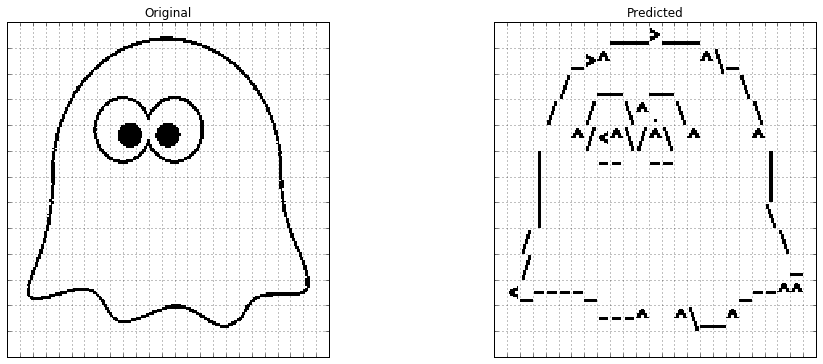

In [91]:
clf = nn.MLPClassifier(hidden_layer_sizes=(20),
                           activation='relu',
                           solver='lbfgs',
                           alpha=0.0001,
                           shuffle=True,
                           verbose=False,
                           warm_start=False,
                           tol=-1000,
                           validation_fraction=0,
                           max_iter=5000,
                           learning_rate='constant',
                           learning_rate_init=0.001)
train_x = np.array([np.array(x[0]).flatten() for x in train_set])
train_y = np.array([np.array(x[2]).flatten() for x in train_set])
to_predict = np.array([t.flatten() for t in tiles])

train_repeats = 5
train_x = np.repeat(train_x, repeats=train_repeats, axis=0)
train_y = np.repeat(train_y, repeats=train_repeats, axis=0)

print("Train x shape: {}, Train y shape: {}".format(train_x.shape, train_y.shape))
print("Input shape: {}".format(to_predict.shape))

model = clf.fit(train_x, train_y)
predicted = model.predict_proba(to_predict)
print("Predicted shape: {}".format(predicted.shape))
#print("Score: {}".format(clf.score(train_x, train_y)))

predicted_tiles = predicted_to_tiles(predicted)
show_tiles(predicted_tiles)

In [92]:
#plt.plot(model.loss_curve_)